# Create Data Files for Workshop

- Full year of hourly data for a single station with extra columns removed
- Extract hourly data for a single 24-hour period from all stations and merge into one CSV file `'weather_airports_24hr_snapshot.csv'`
  - Use UTC time to extract data from the same 24-hour period for all stations
  - May 22, 2018

In [2]:
import pandas as pd

## Full Year of Hourly Data for One Station

Load data, remove unnecessary columns, and save to new csv file

In [94]:
station = 'YVR'
year = 2017
datafile = f'data/processed/weather_hourly_{station}_{year}01-{year}12.csv'
savefile = f'data/workshop/weather_hourly_{station}_{year}.csv'

# Load data
print(f'Reading {datafile}')
df_year = pd.read_csv(datafile, index_col=0)

# Remove unnecessary columns
print('Processing')
cols_drop = ['Station ID', 'Station Name', 'Timezone', 'Datetime (UTC)']
df_year = df_year.drop(cols_drop, axis=1)

# Rename some labels
df_year.index.name = 'Datetime'
df_year = df_year.rename(columns={'Stn Press (kPa)' : 'Pressure (kPa)'})

# Save to CSV
print(f'Saving to {savefile}')
df_year.to_csv(savefile)

# Display the first few rows of the DataFrame
df_year.head()

Reading data/processed/weather_hourly_YVR_201701-201712.csv
Processing
Saving to data/workshop/weather_hourly_YVR_2017.csv


,Temp (deg C),Dew Point Temp (deg C),Rel Hum (%),Wind Dir (deg),Wind Spd (km/h),Visibility (km),Pressure (kPa),Hmdx,Wind Chill,Conditions
Datetime,,,,,,,,,,
2017-01-01 00:00:00,1.2,-0.4,89.0,360.0,8.0,19.3,100.54,NaN,NaN,NaN
2017-01-01 01:00:00,0.9,-0.7,89.0,360.0,2.0,24.1,100.55,NaN,NaN,Cloudy
2017-01-01 02:00:00,1.2,0.6,96.0,80.0,4.0,19.3,100.61,NaN,NaN,Cloudy
2017-01-01 03:00:00,0.6,0.2,97.0,360.0,2.0,19.3,100.65,NaN,NaN,Cloudy
2017-01-01 04:00:00,0.6,0.2,97.0,230.0,3.0,19.3,100.65,NaN,NaN,Cloudy


In [95]:
df_year.describe()

,Temp (deg C),Dew Point Temp (deg C),Rel Hum (%),Wind Dir (deg),Wind Spd (km/h),Visibility (km),Pressure (kPa),Hmdx,Wind Chill
count,8758.000000,8758.000000,8758.000000,8745.000000,8758.000000,8758.000000,8758.000000,446.000000,517.000000
mean,10.249441,6.693663,79.785225,170.810749,13.237040,33.137520,101.601111,26.804933,-5.321083
std,6.632640,5.940729,13.019574,96.231337,7.360099,13.237931,0.853132,1.890264,2.546734
min,-8.400000,-15.700000,18.000000,0.000000,0.000000,0.000000,98.630000,25.000000,-13.000000
25%,5.600000,3.400000,71.000000,90.000000,8.000000,24.100000,101.150000,25.000000,-7.000000
50%,9.800000,6.900000,82.000000,130.000000,12.000000,32.200000,101.630000,26.000000,-5.000000
75%,15.400000,11.200000,90.000000,270.000000,17.000000,48.300000,102.120000,28.000000,-4.000000
max,29.200000,19.200000,100.000000,360.000000,68.000000,64.400000,103.940000,33.000000,0.000000


In [36]:
df_year['Conditions'].value_counts(normalize=True)

Cloudy                                          0.256709
Mostly Cloudy                                   0.208062
Mainly Clear                                    0.205436
Clear                                           0.122987
Rain                                            0.113852
Rain Showers                                    0.027064
Fog                                             0.015530
Rain,Fog                                        0.015074
Snow                                            0.009136
Drizzle,Fog                                     0.004568
Moderate Rain,Fog                               0.004111
Moderate Rain                                   0.003540
Drizzle                                         0.002284
Rain,Drizzle,Fog                                0.001713
Snow Showers                                    0.001599
Rain,Snow                                       0.001370
Snow,Fog                                        0.000914
Rain,Drizzle                   

## 24-hour Snapshot of All Stations

Use UTC date/time to extract the same 24-hour period from each station and merge into a single DataFrame.

In [96]:
def extract_day(datafile, day_utc):
    """Read data from csv file and return DataFrame with subset for the specified UTC day"""
    df_in = pd.read_csv(datafile, index_col='Datetime (UTC)', parse_dates=True)
    
    # Extract data for specifed UTC data
    df = df_in[day_utc]
    
    # Change index to local datetime and shuffle the UTC datetime column over
    df = df.reset_index().set_index('Datetime (Local Standard)')
    columns = df.columns.tolist()
    columns.remove('Datetime (UTC)')
    columns = columns[:3] + ['Datetime (UTC)'] + columns[3:]
    df = df[columns]
    
    # Adjust label for Pressure column
    df = df.rename(columns={'Stn Press (kPa)' : 'Pressure (kPa)'})
    
    return df

In [97]:
# Create a list of station codes sorted by station name
stations_info = pd.read_csv('data/airport_stations.csv', index_col=0)
stations = stations_info.sort_values('Name').index.tolist()
print(stations)

['YYC', 'YYG', 'YEG', 'YFC', 'YHZ', 'YFB', 'YUL', 'YOW', 'YXS', 'YQB', 'YQR', 'YXE', 'YYT', 'YQT', 'YYZ', 'YVR', 'YYJ', 'YXY', 'YWG', 'YZF']


In [98]:
# UTC day to extract
day_utc = '2018-05-22'

# File name for saving the merged data
savefile_snapshot = 'data/workshop/weather_airports_24hr_snapshot.csv'

# Extract specified subset for each station and save as a list of DataFrames
df_list = []
for station in stations:
    datafile = f'data/processed/weather_hourly_{station}_201801-201807.csv'
    df = extract_day(datafile, day_utc)
    df_list.append(df)
    
# Concatenate into a single DataFrame
df_snapshot = pd.concat(df_list, axis=0)

# Save to file
print(f'Saving to {savefile_snapshot}')
df_snapshot.to_csv(savefile_snapshot)

# Display a random sampling of 10 rows
df_snapshot.sample(10, random_state=1)

Saving to data/workshop/weather_airports_24hr_snapshot.csv


,Station ID,Station Name,Timezone,Datetime (UTC),Temp (deg C),Dew Point Temp (deg C),Rel Hum (%),Wind Dir (deg),Wind Spd (km/h),Visibility (km),Pressure (kPa),Hmdx,Wind Chill,Conditions
Datetime (Local Standard),,,,,,,,,,,,,,
2018-05-22 01:30:00,YYT,ST. JOHN'S INTL A,NST,2018-05-22 05:00:00,5.5,2.3,80.0,270.0,23.0,24.1,98.99,NaN,NaN,Mostly Cloudy
2018-05-22 13:00:00,YXE,SASKATOON INTL A,CST,2018-05-22 19:00:00,24.4,6.1,30.0,350.0,7.0,24.1,95.48,NaN,NaN,Mainly Clear
2018-05-22 06:00:00,YYG,CHARLOTTETOWN A,AST,2018-05-22 10:00:00,3.1,1.5,89.0,360.0,1.0,24.1,101.64,NaN,NaN,Clear
2018-05-22 12:00:00,YVR,VANCOUVER INTL A,PST,2018-05-22 20:00:00,18.2,12.1,68.0,240.0,12.0,48.3,101.31,NaN,NaN,Mainly Clear
2018-05-22 14:00:00,YXY,WHITEHORSE A,PST,2018-05-22 22:00:00,12.4,-2.7,35.0,150.0,19.0,64.4,92.32,NaN,NaN,Mostly Cloudy
2018-05-21 19:00:00,YVR,VANCOUVER INTL A,PST,2018-05-22 03:00:00,16.8,10.5,66.0,230.0,6.0,48.3,101.52,NaN,NaN,Clear
2018-05-22 15:00:00,YVR,VANCOUVER INTL A,PST,2018-05-22 23:00:00,19.4,13.2,67.0,240.0,10.0,48.3,101.11,NaN,NaN,Clear
2018-05-22 11:00:00,YEG,EDMONTON INTL A,MST,2018-05-22 18:00:00,24.4,6.0,30.0,120.0,8.0,24.1,93.11,NaN,NaN,Clear
2018-05-22 04:00:00,YQR,REGINA INTL A,CST,2018-05-22 10:00:00,13.2,4.9,57.0,210.0,8.0,24.1,94.32,NaN,NaN,Mostly Cloudy


## Data Exploration

In [99]:
df_snapshot['Datetime (UTC)'].unique()

array(['2018-05-22T00:00:00.000000000', '2018-05-22T01:00:00.000000000',
       '2018-05-22T02:00:00.000000000', '2018-05-22T03:00:00.000000000',
       '2018-05-22T04:00:00.000000000', '2018-05-22T05:00:00.000000000',
       '2018-05-22T06:00:00.000000000', '2018-05-22T07:00:00.000000000',
       '2018-05-22T08:00:00.000000000', '2018-05-22T09:00:00.000000000',
       '2018-05-22T10:00:00.000000000', '2018-05-22T11:00:00.000000000',
       '2018-05-22T12:00:00.000000000', '2018-05-22T13:00:00.000000000',
       '2018-05-22T14:00:00.000000000', '2018-05-22T15:00:00.000000000',
       '2018-05-22T16:00:00.000000000', '2018-05-22T17:00:00.000000000',
       '2018-05-22T18:00:00.000000000', '2018-05-22T19:00:00.000000000',
       '2018-05-22T20:00:00.000000000', '2018-05-22T21:00:00.000000000',
       '2018-05-22T22:00:00.000000000', '2018-05-22T23:00:00.000000000'],
      dtype='datetime64[ns]')

In [100]:
df_snapshot.describe()

,Temp (deg C),Dew Point Temp (deg C),Rel Hum (%),Wind Dir (deg),Wind Spd (km/h),Visibility (km),Pressure (kPa),Hmdx,Wind Chill
count,479.000000,479.000000,479.000000,463.000000,479.000000,479.000000,479.000000,41.000000,25.00000
mean,13.863048,4.186848,56.895616,200.064795,13.229645,28.620459,98.038685,26.414634,-12.72000
std,7.902422,5.293279,21.899580,96.554249,9.258575,13.252858,3.707711,1.244500,2.37206
min,-7.100000,-11.000000,15.000000,0.000000,0.000000,3.200000,88.740000,25.000000,-15.00000
25%,8.800000,0.650000,37.000000,140.000000,6.000000,24.100000,94.645000,25.000000,-14.00000
50%,14.600000,4.700000,56.000000,200.000000,11.000000,24.100000,99.490000,26.000000,-13.00000
75%,19.050000,8.050000,76.500000,270.000000,18.000000,32.200000,101.005000,27.000000,-12.00000
max,28.600000,14.600000,97.000000,360.000000,54.000000,64.400000,102.000000,29.000000,-3.00000


In [101]:
df_snapshot['Conditions'].value_counts()

Mostly Cloudy                 147
Mainly Clear                  109
Clear                          81
Rain                           61
Cloudy                         39
Snow                           14
Rain Showers                   10
Fog                             8
Drizzle,Fog                     3
Rain,Fog                        3
Thunderstorms,Rain Showers      2
Snow,Blowing Snow               2
Name: Conditions, dtype: int64

In [102]:
freezing = df_snapshot['Temp (deg C)'] <= 0
freezing.sum()

25

In [103]:
df_snapshot[freezing]

,Station ID,Station Name,Timezone,Datetime (UTC),Temp (deg C),Dew Point Temp (deg C),Rel Hum (%),Wind Dir (deg),Wind Spd (km/h),Visibility (km),Pressure (kPa),Hmdx,Wind Chill,Conditions
Datetime (Local Standard),,,,,,,,,,,,,,
2018-05-22 04:00:00,YYG,CHARLOTTETOWN A,AST,2018-05-22 08:00:00,-1.4,-2.0,95.0,350.0,5.0,24.1,101.48,NaN,-3.0,Clear
2018-05-21 19:00:00,YFB,IQALUIT A,EST,2018-05-22 00:00:00,-4.6,-9.1,71.0,340.0,29.0,48.3,100.69,NaN,-12.0,Cloudy
2018-05-21 20:00:00,YFB,IQALUIT A,EST,2018-05-22 01:00:00,-5.5,-10.8,67.0,340.0,23.0,48.3,100.72,NaN,-13.0,Cloudy
2018-05-21 21:00:00,YFB,IQALUIT A,EST,2018-05-22 02:00:00,-6.0,-10.7,70.0,330.0,13.0,48.3,100.73,NaN,-11.0,Cloudy
2018-05-21 22:00:00,YFB,IQALUIT A,EST,2018-05-22 03:00:00,-6.1,-9.5,77.0,320.0,14.0,32.2,100.72,NaN,-12.0,Snow
2018-05-21 23:00:00,YFB,IQALUIT A,EST,2018-05-22 04:00:00,-6.2,-9.4,78.0,330.0,17.0,24.1,100.70,NaN,-12.0,Snow
2018-05-22 00:00:00,YFB,IQALUIT A,EST,2018-05-22 05:00:00,-6.3,-9.2,80.0,330.0,19.0,24.1,100.67,NaN,-13.0,Snow
2018-05-22 01:00:00,YFB,IQALUIT A,EST,2018-05-22 06:00:00,-6.4,-9.1,81.0,340.0,20.0,24.1,100.66,NaN,-13.0,Snow
2018-05-22 02:00:00,YFB,IQALUIT A,EST,2018-05-22 07:00:00,-6.6,-9.1,83.0,330.0,16.0,16.1,100.64,NaN,-13.0,Snow


In [104]:
df_snapshot[df_snapshot['Station Name'] == 'CHARLOTTETOWN A']

,Station ID,Station Name,Timezone,Datetime (UTC),Temp (deg C),Dew Point Temp (deg C),Rel Hum (%),Wind Dir (deg),Wind Spd (km/h),Visibility (km),Pressure (kPa),Hmdx,Wind Chill,Conditions
Datetime (Local Standard),,,,,,,,,,,,,,
2018-05-21 20:00:00,YYG,CHARLOTTETOWN A,AST,2018-05-22 00:00:00,8.2,0.0,56.0,360.0,16.0,24.1,100.98,NaN,NaN,Mainly Clear
2018-05-21 21:00:00,YYG,CHARLOTTETOWN A,AST,2018-05-22 01:00:00,5.4,0.8,72.0,10.0,8.0,24.1,101.12,NaN,NaN,Mainly Clear
2018-05-21 22:00:00,YYG,CHARLOTTETOWN A,AST,2018-05-22 02:00:00,4.3,0.6,77.0,120.0,4.0,24.1,101.21,NaN,NaN,Mainly Clear
2018-05-21 23:00:00,YYG,CHARLOTTETOWN A,AST,2018-05-22 03:00:00,5.3,0.8,73.0,190.0,3.0,24.1,101.29,NaN,NaN,Clear
2018-05-22 00:00:00,YYG,CHARLOTTETOWN A,AST,2018-05-22 04:00:00,1.5,-0.4,87.0,180.0,5.0,24.1,101.28,NaN,NaN,Clear
2018-05-22 01:00:00,YYG,CHARLOTTETOWN A,AST,2018-05-22 05:00:00,1.6,-0.3,87.0,360.0,3.0,24.1,101.29,NaN,NaN,Clear
2018-05-22 02:00:00,YYG,CHARLOTTETOWN A,AST,2018-05-22 06:00:00,4.3,0.6,77.0,240.0,9.0,24.1,101.36,NaN,NaN,Clear
2018-05-22 03:00:00,YYG,CHARLOTTETOWN A,AST,2018-05-22 07:00:00,1.5,0.6,94.0,250.0,3.0,24.1,101.41,NaN,NaN,Clear
2018-05-22 04:00:00,YYG,CHARLOTTETOWN A,AST,2018-05-22 08:00:00,-1.4,-2.0,95.0,350.0,5.0,24.1,101.48,NaN,-3.0,Clear


In [105]:
warm = df_snapshot['Temp (deg C)'] > 25
warm.sum()

38

In [76]:
df_snapshot.loc[warm, 'Station Name'].value_counts()

REGINA INTL A       8
WINNIPEG INTL A     8
THUNDER BAY A       7
SASKATOON INTL A    6
EDMONTON INTL A     3
QUEBEC INTL A       2
PRINCE GEORGE       2
CALGARY INTL A      2
Name: Station Name, dtype: int64

In [83]:
agg_funcs = {'Temp (deg C)' : ['min', 'mean', 'max']}
temp_stats = df_snapshot.groupby('Station Name').agg(agg_funcs)
temp_stats

Temp (deg C)                 
                           min       mean   max
Station Name                                   
CALGARY INTL A            10.1  18.054167  25.5
CHARLOTTETOWN A           -1.4   8.637500  17.7
EDMONTON INTL A            5.2  17.558333  27.3
FREDERICTON                0.7  12.373913  21.8
HALIFAX INTL A             6.9  12.237500  17.4
IQALUIT A                 -7.1  -5.350000  -2.8
MONTREAL INTL A           12.9  17.479167  22.4
OTTAWA INTL A             12.3  15.537500  22.1
PRINCE GEORGE              4.2  14.337500  25.9
QUEBEC INTL A              6.5  15.366667  25.6
REGINA INTL A              9.8  21.337500  28.6
SASKATOON INTL A          12.1  19.308333  28.6
ST. JOHN'S INTL A          3.0   4.862500   7.8
THUNDER BAY A              0.9  14.625000  28.2
TORONTO INTL A            11.4  14.833333  20.1
VANCOUVER INTL A          10.4  15.262500  19.5
VICTORIA INTL A           10.0  15.658333  22.6
WHITEHORSE A               4.8   9.183333  13.8
WINNIPEG INTL A           12.0  20.495833  28.5
YELLOWKNIFE A              7.0  15.400000  23.1

In [81]:
%matplotlib inline

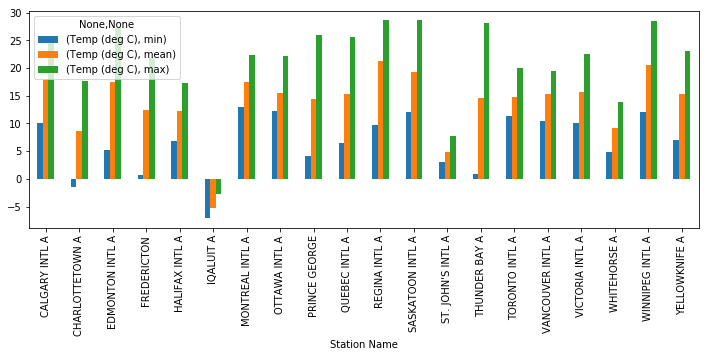

In [84]:
temp_stats.plot.bar(figsize=(12, 4))